In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Using MacBook Mps
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


In [ ]:
# 1. Preapering data:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
#2. Pandas for data preapring
data = pd.read_excel('data_50k.xlsx')

In [ ]:
# DataSeperation
X = data.drop(columns=['Y']).values
y = data['Y'].values

In [ ]:
# removing the outliners
from sklearn.covariance import EllipticEnvelope
envelope = EllipticEnvelope(contamination=0.01)
mask = envelope.fit_predict(X) == 1
X, y = X[mask], y[mask]

In [ ]:
# Standaryzation the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Balansing the data - SMOTE + Undersampling
smote = SMOTE(sampling_strategy=0.8, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [9]:
undersample = RandomUnderSampler(sampling_strategy=0.8)
X_res, y_res = undersample.fit_resample(X_res, y_res)

In [ ]:
# Train and validate set
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)


In [ ]:
# Creating Dataset
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# 2. Model Architecture
class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate, num_classes):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x, _ = self.gru(x.unsqueeze(1))  # batch size batch_first
        x = x[:, -1, :]  # taking the last hidden state
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [13]:
# Parametry sieci
input_size = X.shape[1]
hidden_size = 100
num_layers = 3
dropout_rate = 0.3
num_classes = 2


In [14]:
model = GRUNet(input_size, hidden_size, num_layers, dropout_rate, num_classes).to(device)


In [ ]:
# 3. Cost Function, optyoptymalizer i class weights
weights = torch.tensor([1.0, 1.5], device=device)  # class weights 
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.0005)


/Users/lfras/anaconda3/envs/VS_nlp_01/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# Early stopping
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None or score > self.best_score:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
# 4. Trening the model
early_stopping = EarlyStopping(patience=5)

for epoch in range(100):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss, y_pred, y_true = 0, [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())

    val_loss /= len(val_loader)
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Acc: {acc:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break



Epoch 1, Loss: 0.5780, Val Loss: 0.5617, Acc: 0.7031, Recall: 0.7307, F1: 0.6863
Epoch 2, Loss: 0.5663, Val Loss: 0.5602, Acc: 0.7021, Recall: 0.7477, F1: 0.6905
Epoch 3, Loss: 0.5631, Val Loss: 0.5583, Acc: 0.7022, Recall: 0.7532, F1: 0.6921
Epoch 4, Loss: 0.5603, Val Loss: 0.5571, Acc: 0.7067, Recall: 0.7272, F1: 0.6879
Epoch 5, Loss: 0.5575, Val Loss: 0.5559, Acc: 0.7067, Recall: 0.7197, F1: 0.6856
Epoch 6, Loss: 0.5566, Val Loss: 0.5541, Acc: 0.7090, Recall: 0.7326, F1: 0.6911
Epoch 7, Loss: 0.5543, Val Loss: 0.5553, Acc: 0.7072, Recall: 0.7262, F1: 0.6879
Epoch 8, Loss: 0.5541, Val Loss: 0.5529, Acc: 0.7135, Recall: 0.7051, F1: 0.6862
Epoch 9, Loss: 0.5531, Val Loss: 0.5510, Acc: 0.7103, Recall: 0.7177, F1: 0.6876
Epoch 10, Loss: 0.5507, Val Loss: 0.5507, Acc: 0.7132, Recall: 0.7297, F1: 0.6934
Epoch 11, Loss: 0.5500, Val Loss: 0.5501, Acc: 0.7091, Recall: 0.7353, F1: 0.6919
Epoch 12, Loss: 0.5489, Val Loss: 0.5517, Acc: 0.7101, Recall: 0.7287, F1: 0.6908
Epoch 13, Loss: 0.5465, V

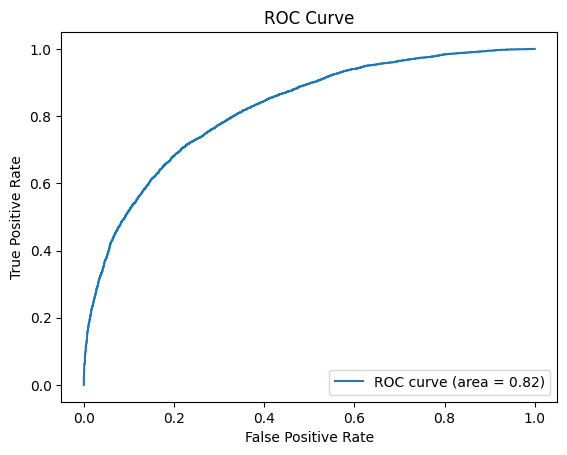

ROC AUC: 0.8212, Gini: 0.6424


In [ ]:
# 5. Calculating the metrics ROC AUC & Gini

probs = torch.softmax(torch.cat([model(torch.tensor(x, dtype=torch.float32, device=device).unsqueeze(0)).cpu() for x in X_val]), dim=1)


fpr, tpr, _ = roc_curve(y_val, probs[:, 1].detach().numpy())
roc_auc = auc(fpr, tpr)
gini = 2 * roc_auc - 1

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC: {roc_auc:.4f}, Gini: {gini:.4f}")

In [ ]:
# Saving model to pth file, for using in docker&gast api  mickroservices
torch.save(model.state_dict(), "uru_kom_model_bestResult_ver7.pth")
print("Model saved to 'gru_model.pth'")


Model saved to 'gru_model.pth'
